# Attention Scoring Functions
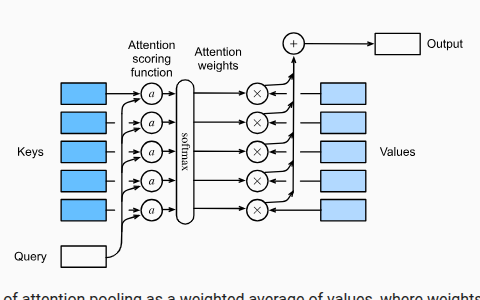
- Scaled dot product attention $a(\mathbf{q}, \mathbf{k}_i) = \mathbf{q}^{\top} \mathbf{k}_i / \sqrt{\bar{d}}.$
- still need to normalize with softmax so eq:
$$
\alpha(\mathbf{q}, \mathbf{k}_i) = \text{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = 
\frac{\exp(\mathbf{q}^{\top} \mathbf{k}_i / \sqrt{\bar{d}})}
{\sum_{j=1} \exp(\mathbf{q}^{\top} \mathbf{k}_j / \sqrt{\bar{d}})}.
$$
- we need convience functions to compute the attention scores for all keys in a batch.
  - masked softmax operation

$$
\text{softmax} \left( \frac{\mathbf{Q} \mathbf{K}^{\top}}{\sqrt{d}} \right) \mathbf{V} \in \mathbb{R}^{n \times v}.
$$

additive attention 
$$
a(\mathbf{q}, \mathbf{k}) = \mathbf{w}_v^{\top} \tanh (\mathbf{W}_q \mathbf{q} + \mathbf{W}_k \mathbf{k}) \in \mathbb{R},
$$
An equivalent interpretation  is that the query and key are concatenated and fed into an MLP with a single hidden layer. Using 
 as the activation function and disabling bias terms, we implement additive attention as follows:

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

/home/athapar/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)
        mask = mask[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1]) 
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative, becomes 0 when goes trough softmax
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)


In [ ]:
# 2 examples, 
# first: mask cols >=2
# second: mask cols >=3
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))


tensor([[[0.5326, 0.4674, 0.0000, 0.0000],
         [0.6156, 0.3844, 0.0000, 0.0000]],

        [[0.2710, 0.2646, 0.4645, 0.0000],
         [0.2489, 0.3900, 0.3611, 0.0000]]])

In [5]:
# 2 examples,
# first: mask row 1 col 1 onwards, row 2 col 3 onwards
# second: mask row 1 col 2 onwards, row 2 col 4 onwards
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2968, 0.3465, 0.3567, 0.0000]],

        [[0.3978, 0.6022, 0.0000, 0.0000],
         [0.2551, 0.1576, 0.3679, 0.2194]]])

In [ ]:
# Batch matrix multiplication
# If input is a (b \times n \times m) tensor, eg. 2, 3, 4
# mat2 is a (b \times m \times p) tensor,  eg. 2, 4, 6
# out will be a (b \times n \times p) tensor. eg. 2, 3, 6
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6)) # passes
torch.bmm(Q, K)

tensor([[[4., 4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4., 4.]],

        [[4., 4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4., 4.]]])

In [13]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [ ]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])
# qk(trapnspose) => (2,1, 10) (attention_weights) then x vals (2, 10, 4) --> (2, 1, 4)

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

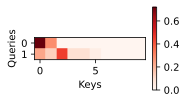

In [ ]:
# see vanish 2, 6 cols respectively
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [26]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

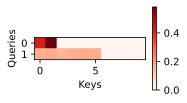

In [29]:
queries = torch.normal(0, 1, (2, 1, 20)) # mismatch with keys (2), thus do additive
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')